In [1]:
from ssht_heatnet import HeatNet
from ssht_datageneration import generate_domain_points, generate_boundary_points
from ssht_loss_fns import pde_loss_2d, bc_loss_2d, data_loss_2d

import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


In [15]:
# generating data for the data loss (data points - where the prediction is compared to true values)

#def analytic_solution(x, y, terms = 40):

#    T = np.zeros_like(x)
 #   for n in range(1, 2*terms, 2):  # odd n only
  #      coef = (4 / (n * np.pi))
   #     numerator = np.sinh(n * np.pi * y)
    #    denominator = np.sinh(n * np.pi)
     #   T += coef * (numerator / denominator) * np.sin(n * np.pi * x)
    #return T

def f(x, sigma=0.25):
    return np.exp(-((x - 0.5)**2) / (2 * sigma**2))

def compute_An(n, sigma=0.25):
    x_vals = np.linspace(0, 1, 1000)
    integrand = f(x_vals, sigma) * np.sin(n * np.pi * x_vals)
    return 2 * np.trapezoid(integrand, x_vals)

def analytic_solution_gaussian(x, y, terms=40, sigma=0.25):
    T = np.zeros_like(x)
    for n in range(1, terms+1):
        An = compute_An(n, sigma)
        numerator = np.sinh(n * np.pi * y)
        denominator = np.sinh(n * np.pi)
        T += An * (numerator / denominator) * np.sin(n * np.pi * x)
    return T


n_data = 100
x_data, y_data = generate_domain_points(n_data)
T_data = analytic_solution_gaussian(x_data, y_data, terms=50)


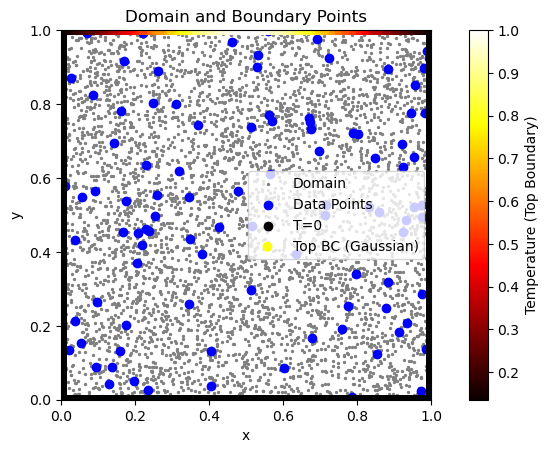

In [3]:
# generating specific training data (collocation points - where the pde residual is calculated)

n_domain = 5000
n_bc = 2500
x_domain, y_domain = generate_domain_points(n_domain)
x_bc, y_bc, t_bc = generate_boundary_points(n_bc)

plt.scatter(x_domain, y_domain, c='gray', s=2, label='Domain')
plt.scatter(x_data, y_data, c='b', label='Data Points')
plt.scatter(x_bc[t_bc==0], y_bc[t_bc==0], c='k', label='T=0')
#plt.scatter(x_bc[t_bc==1], y_bc[t_bc==1], c='r', label='T=1')

# Plot the top boundary with a colormap for temperature
top_mask = (y_bc == 1.0)
plt.scatter(x_bc[top_mask], y_bc[top_mask], c=t_bc[top_mask], cmap='hot', label='Top BC (Gaussian)')
plt.colorbar(label='Temperature (Top Boundary)')


plt.xlabel('x')
plt.ylabel('y')
plt.title('Domain and Boundary Points')
plt.legend()
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [4]:
#instantiate the model

model = HeatNet(
    input_dim=2, output_dim=1, n_units=60, epochs=1000, lr=0.001,
    pde_loss=pde_loss_2d, bc_loss=bc_loss_2d, pde_weight=1.0, bc_weight=100.0,
    use_ffe=True, num_frequencies=32, fourier_scale=1,
    data_loss=data_loss_2d, data_weight=1.0)

Epoch 0: Loss (tot) 27.637, Loss (pde) 16.36344337463379, Loss (bc) 11.178638458251953, Loss (data) 0.09530752897262573 
Epoch 100: Loss (tot) 0.207, Loss (pde) 0.11566133052110672, Loss (bc) 0.08206932991743088, Loss (data) 0.009124893695116043 
Epoch 200: Loss (tot) 0.077, Loss (pde) 0.030293133109807968, Loss (bc) 0.03776947781443596, Loss (data) 0.008484568446874619 
Epoch 300: Loss (tot) 0.062, Loss (pde) 0.023127956315875053, Loss (bc) 0.030828086659312248, Loss (data) 0.008421333506703377 
Epoch 400: Loss (tot) 0.070, Loss (pde) 0.03361884504556656, Loss (bc) 0.027481408789753914, Loss (data) 0.008567986078560352 
Epoch 500: Loss (tot) 0.044, Loss (pde) 0.010904843918979168, Loss (bc) 0.024543365463614464, Loss (data) 0.008263792842626572 
Epoch 600: Loss (tot) 0.100, Loss (pde) 0.06761248409748077, Loss (bc) 0.024117719382047653, Loss (data) 0.008599788881838322 
Epoch 700: Loss (tot) 0.044, Loss (pde) 0.014830013737082481, Loss (bc) 0.02127796597778797, Loss (data) 0.008303690

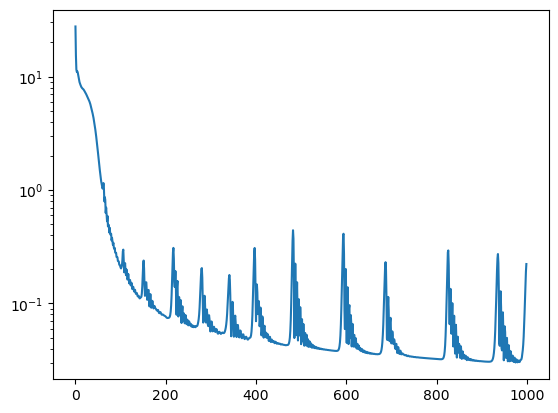

In [5]:
#losses calculation


losses = model.fit(x_domain, y_domain, x_bc, y_bc, t_bc, x_data, y_data, T_data)

plt.plot(losses)
plt.yscale('log')

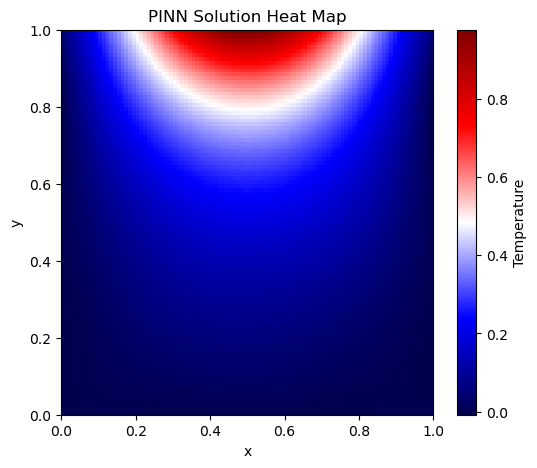

In [6]:
# now using the pinn, trained on random data, to estimate the solution to the heat equation everywhere
# in the grid, ie giving a heat map


# Create a regular grid
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()


# Predict on the grid
xy = torch.tensor(np.stack([x_flat, y_flat], axis=1), dtype=torch.float32)
with torch.no_grad():
    T_pred = model(xy).cpu().numpy().reshape(n, n)


# Plot heatmap
plt.figure(figsize=(6,5))
plt.imshow(T_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PINN Solution Heat Map')
plt.show()

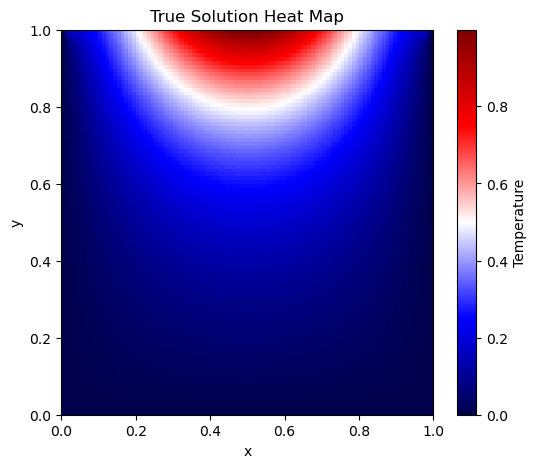

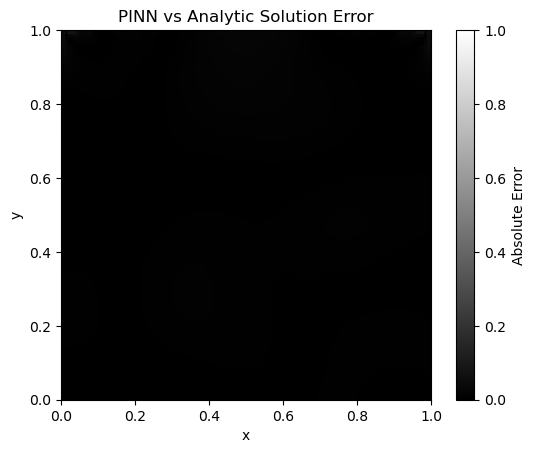

In [18]:
# Now to see a heatmap of the error (analytic solution - PINNs predictions)
    
T_true_grid = analytic_solution_gaussian(X, Y)
error_grid = np.abs(T_pred - T_true_grid)

plt.figure(figsize=(6,5))
plt.imshow(T_true_grid, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True Solution Heat Map')
plt.show()

plt.imshow(error_grid, extent=[0,1,0,1], origin='lower', cmap='gray', vmin=0, vmax=1)
# extent=[xmin, xmax, ymin, ymax] ;  imshow puts origin top left so 'lower' moves it to bottom left
plt.colorbar(label='Absolute Error')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PINN vs Analytic Solution Error')
plt.show()